# Algorithm

The Map Matching algorithm used here is based on an HMM where we want to decode the most likely path (Viterbi decoding) based on a sequence of position observations.

In [1]:
import os, sys, importlib, math
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sys.path.append(os.path.join(os.getcwd(), os.pardir))
import dtaimapmatching as mm
from dtaimapmatching import visualization as mm_visualization

## Data

The input data are:

- A graph representing the road network. A vertex is a point on a road or an intersection with an associated location, an edge is a road between two points.
- A path representing a sequence of position observations (e.g., a series of latitude -longitude points).

## Model

### States

The set of states $S = G_v \cup G_e$ with:

- $G_v$ is all vertices in the graph $G$
- $G_e$ is all edges in the graph $G$

The possible transitions are $T = S \times S$ where 

\begin{align}
\forall (s_i,s_j) \in T: & (s_i,s_j) \in G_e \textrm{, or} \\
& s_i = s_j \textrm{ and } s_i \in S \textrm{, or} \\
& s_i = (s_{i,k},s_{i,l}) \in G_e \textrm{ and } s_{i,l} = s_j \in G_v \textrm{, or} \\
& s_j = (s_{j,k},s_{j,l}) \in G_e \textrm{ and } s_{j,k} = s_i \in G_v
\end{align}

All transitions in $T$ have a probability of $1.0$. This transition probability can be adapted to previous behaviour of the tracked object (e.g., expect a similar speed).

### Observations

A measurement can be disturbed due to Gaussian noise, $X \sim \mathcal{N}(0, \sigma^2_n)$ with $\sigma^2_n$ is the standard deviation of the noise on the observation:

\begin{equation}
    Pr(o_i|s_i) = 2\cdot X(d(o_i, s_i))
\end{equation}

Where $s_i$ is the i-th state, $o_i$ is the i-th observation, and $d$ depends on the type of state:

- $d(o_i, s_i) = distance(o_i, s_i)$ if $s_i \in G_v$
- $d(o_i, s_i) = distance(o_i, p_i)$ where $p_i$ is the orthogonal projection of $o_i$ on segment $e$ if $s_i \in G_e$.

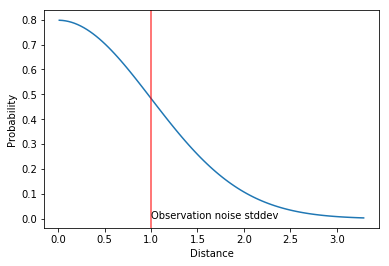

In [2]:
mm_visualization.plot_obs_noise_dist(mm.matching.Matcher(map, obs_noise=1))
plt.savefig('observation_noise.png')

## Task

The goal is to find the sequence of states $\mathbf{s} = [s_0, s_1, \dots, s_m]$ where $s_i \in S$ that minimizes the probability that the observations $\mathbf{o} = [o_0, o_1, \dots, o_m]$ are due to noise or maximizes the probability that the observation is close to the actual position with the assumption that the actual position is a position on the graph (either on a vertex or on an edge):

\begin{equation}
\max Pr(\mathbf{s} | \mathbf{o}) = \sum_{i=1}^m Pr(o_i | s_i) \cdot Pr(s_i|s_{i-1})\cdot Pr(o_0 | s_0) \cdot Pr(s_0)
\end{equation}

## Including behaviour

In case we want to model the behaviour of the object we are tracking, we can refine the possible states. Where now the states are a vertex or an edge, this can be refined to an actual position on an edge. The challenge now is that $\Pr(s_i | s_{i-1})$ is a continuous distribution instead of a discrete (this is typically solved by a Particle Filter or Kalman filter not a HMM).

This is not yet implemented in the toolbox. An approximation is implemented where the probability of the next state takes the average speed and the previous positions into account. But only for the orthogonal projection on the edge or the vertex and not any position on the edge.